## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize

## Загружаем исходные данные

In [2]:
train = np.loadtxt('../../data/digit-recognizer/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('../../data/digit-recognizer/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

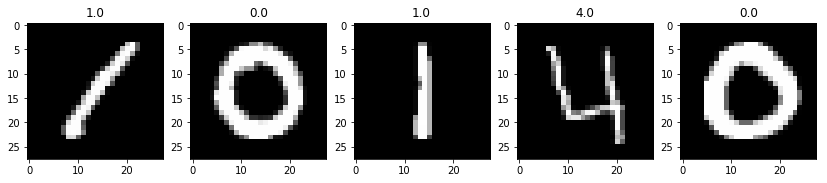

In [4]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [5]:
# Предобработаем изображения
def crop_normalize_blur(image):
    return cv2.GaussianBlur(normalize(image[3:-4, 4:-3]), (3,3), 0) 

In [6]:
# Вычисляем X и Y составляющие градиента с помощью оператора Собеля
def sobel(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, dx=1, dy=0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, dx=0, dy=1, ksize=3)
    return sobel_x, sobel_y

## Вычисляем гистограммы градиентов

In [7]:
def gradient_histogram(gradient, theta, number_of_bins=16):
    # Гистограммы вычисляются с учетом длины вектора градиента
    hist_columns = []
    for gradient_row, theta_row in zip(np.split(gradient, 3), np.split(theta, 3)):
        hist_row = []
        for gradient_cell, theta_cell in zip(np.split(gradient_row, 3, axis=1), np.split(theta_row, 3, axis=1)):
            hist, borders = np.histogram(
                theta_cell,
                bins=number_of_bins,
                range=(0., 2. * np.pi),
                weights=gradient_cell
            )
            hist_row.append(hist)
        hist_columns.append(hist_row)
    return np.array(hist_columns)

In [8]:
def blocks_normalize(histogram_grid):
    blocks = [
        histogram_grid[:2, :2, :],
        histogram_grid[1:, :2, :],
        histogram_grid[:2, 1:, :],
        histogram_grid[1:, 1:, :],
    ]
    features = np.stack(normalize(block.reshape(1, -1)) for block in blocks).reshape(-1)
    return features

In [9]:
def get_features(images):
    for image in images:
#         Вычисляем угол и длину вектора градиента
        gradient, theta = cv2.cartToPolar(*sobel(crop_normalize_blur(image)))
        features = blocks_normalize(gradient_histogram(gradient, theta))
        yield features

## Оцениваем качество решение на валидационной выборке

In [10]:
# PCA visualization - dont know how to use opencv, use sklearn?
# sort histogram max first - fail??
# detect thingy on image?
# rotate image?

In [11]:
%%time
train_data = np.stack(get_features(train_img))

CPU times: user 38.8 s, sys: 60 ms, total: 38.9 s
Wall time: 38.9 s


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

In [13]:
model = LinearSVC(random_state=42, multi_class='crammer_singer')
print(cross_val_score(model, train_data, train_label, cv=4))

[ 0.97124631  0.97142857  0.96752381  0.97303992]


In [14]:
model = LinearSVC(random_state=42, multi_class='crammer_singer')
model.fit(train_data, train_label)
predicted_label = model.predict(train_data)

In [15]:
print('Accuracy: %s' % accuracy_score(train_label, predicted_label))
print(classification_report(train_label, predicted_label))
print(confusion_matrix(train_label, predicted_label))

Accuracy: 0.978428571429
             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99      4132
        1.0       0.99      0.99      0.99      4684
        2.0       0.98      0.97      0.98      4177
        3.0       0.97      0.97      0.97      4351
        4.0       0.98      0.98      0.98      4072
        5.0       0.98      0.98      0.98      3795
        6.0       0.99      0.99      0.99      4137
        7.0       0.97      0.98      0.97      4401
        8.0       0.97      0.96      0.97      4063
        9.0       0.97      0.96      0.96      4188

avg / total       0.98      0.98      0.98     42000

[[4109    2    5    0    4    1    6    1    2    2]
 [   0 4642   11    0   11    1    5   13    0    1]
 [   5   12 4070   26    5    1    1   35   17    5]
 [   6    2   30 4216    0   29    0   17   30   21]
 [   3   11    3    1 3993    0   14   12   10   25]
 [   2    4    3   30    1 3720   11    2   16    6]
 [   8    4    1  

## Предсказания на тестовых данных

In [16]:
predicted_test = model.predict(np.stack(get_features(test_img)))

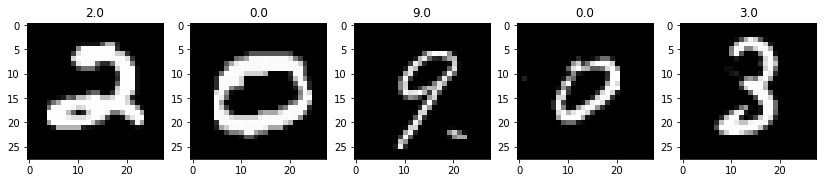

In [17]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % predicted_test[i - 1]);

## Готовим файл для отправки

In [19]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(predicted_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

# 0.97214